In [15]:
# For data manipulation
import os
from dotenv import load_dotenv
from tvDatafeed import TvDatafeedLive, Interval
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Load environment variables from .env file
load_dotenv()

# Retrieve TradingView credentials from environment variables
username = os.environ.get("TRADINGVIEW_USERNAME")
password = os.environ.get("TRADINGVIEW_PASSWORD")

# Initialize TradingView live data feed
tv = TvDatafeedLive(username, password)

# Fetch historical data for XAUUSD (2000 hourly bars)
forex_data_lowertf = tv.get_hist(symbol='XAUUSD', exchange='ICMARKETS',
                              interval=Interval.in_5_minute, n_bars=4000)

forex_data_lowertf['close']


datetime
2024-10-17 04:25:00    2677.81
2024-10-17 04:30:00    2676.67
2024-10-17 04:35:00    2679.63
2024-10-17 04:40:00    2680.76
2024-10-17 04:45:00    2681.75
                        ...   
2024-11-06 17:20:00    2665.88
2024-11-06 17:25:00    2668.36
2024-11-06 17:30:00    2670.34
2024-11-06 17:35:00    2673.87
2024-11-06 17:40:00    2671.27
Name: close, Length: 4000, dtype: float64

In [16]:
import numpy as np
import pandas as pd

def essf(series, period):
    """Ehlers' SuperSmoother Filter (ESSF)"""
    SQRT2xPI = np.sqrt(2.0) * np.pi
    alpha = SQRT2xPI / period
    beta = np.exp(-alpha)
    coef2 = -beta ** 2
    coef1 = 2.0 * beta * np.cos(alpha)
    coef0 = 1.0 - coef1 - coef2

    # Calculate sma2
    sma2 = (series + series.shift(1).fillna(series)) * 0.5

    # Initialize ESSF array
    ess = np.full(len(series), np.nan)
    ess[0] = sma2.iloc[0]

    for t in range(1, len(series)):
        sma2_t = sma2.iloc[t]
        ess_t1 = ess[t - 1]
        ess_t2 = ess[t - 2] if t - 2 >= 0 else 0.0

        ess[t] = coef0 * sma2_t + coef1 * ess_t1 + coef2 * ess_t2

    return pd.Series(ess, index=series.index)

def sum_diffs(series, period):
    """Sum of Differences"""
    E = np.zeros(len(series))
    for i in range(1, period + 1):
        shifted_series = series.shift(i).fillna(0)
        E += (series - shifted_series)
    E /= period
    return pd.Series(E, index=series.index)

def ema_recursive(series, period):
    """Exponential Moving Average (EMA) calculated recursively"""
    coef0 = 2.0 / (period + 1.0)
    coef1 = 1.0 - coef0
    EMA = np.full(len(series), np.nan)
    EMA[0] = series.iloc[0]

    for t in range(1, len(series)):
        series_t = series.iloc[t]
        EMA_t1 = EMA[t - 1]
        EMA[t] = coef0 * series_t + coef1 * EMA_t1

    return pd.Series(EMA, index=series.index)

def fRMS(series, period):
    """Fast Root Mean Square (fRMS)"""
    squared_series = series ** 2
    ema_squared = ema_recursive(squared_series, period)
    sqrt_ema = np.sqrt(ema_squared)
    result = np.nan_to_num(series / sqrt_ema, 0)
    return result

def trendflex(series, period_essf, period_tflx, period_frms):
    """Ehlers' TrendFlex Oscillator (TFO)"""
    essf_filtered = essf(series, period_essf)
    sum_diffs_filtered = sum_diffs(essf_filtered, period_tflx)
    tfo = fRMS(sum_diffs_filtered, period_frms)
    return tfo


# Parameters
periodTrendFlex = 20
useSuperSmootherOverride = False
periodSuperSmoother = 7.5
postSmooth = 33.0

# Adjust periodSuperSmoother if override is not used
if not useSuperSmootherOverride:
    periodSuperSmoother = periodTrendFlex * 0.5

# Calculate TFO
forex_data_lowertf['TFO'] = trendflex(forex_data_lowertf['close'], periodSuperSmoother, periodTrendFlex, postSmooth)


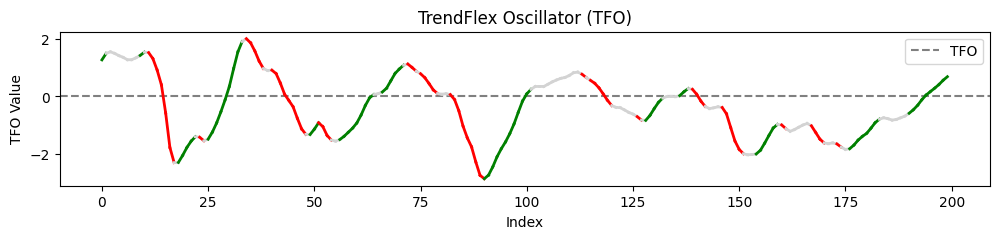

In [28]:
data_for_plot = forex_data_lowertf[-200:]

plt.figure(figsize=(12, 2))
plt.axhline(0, color='grey', linestyle='--')

# Calculate the slope of the TFO line
tfo_values = data_for_plot['TFO']
tfo_slope = tfo_values.diff()

# Plot the TFO line with color based on the slope
for i in range(1, len(tfo_values)):
    if tfo_slope.iloc[i] >= 0.1:
        plt.plot([i-1, i], [tfo_values.iloc[i-1], tfo_values.iloc[i]], color='green', linewidth=2)
    elif tfo_slope.iloc[i] <= -0.1:
        plt.plot([i-1, i], [tfo_values.iloc[i-1], tfo_values.iloc[i]], color='red', linewidth=2)
    else:
        plt.plot([i-1, i], [tfo_values.iloc[i-1], tfo_values.iloc[i]], color='lightgrey', linewidth=2)

plt.legend(['TFO'])
plt.title('TrendFlex Oscillator (TFO)')
plt.xlabel('Index')
plt.ylabel('TFO Value')
plt.show()
